In [1]:
import sys
sys.path.append('src')
import numpy as np
from sts_sensor import StsSensor
from particle_gun import ParticleGun
from sts_track import StsTrack

import matplotlib.pyplot as plt


##### Generate tracks

In [2]:
n_of_trks = 1000
gun = ParticleGun(r0=[.0, .0, .0], dr=[.0, .0, 0], p0=[0, 0, 1], dp=[.05, .05, .0], mass=0.938)
particles = gun.generate(n_of_trks)

##### Define geometry planes

In [ ]:
sensors = [StsSensor(address=i, position=(0,0,10*(i+1)), orientation=(0,0), size=6, resolution=(0.01, 0.01, 0.0)) for i in range(8)]
sensors_locked = [0,7]

alignment = [
    [0]*5 for i,s in enumerate(sensors)
]

def align_sensors(matrix):
    for i in range(len(sensors)):
        sensors[i].position[0] += matrix[i][0]
        sensors[i].position[1] += matrix[i][1]
        sensors[i].position[2] += matrix[i][2]
        sensors[i].theta       += matrix[i][3]
        sensors[i].phi         += matrix[i][4]

# Manual miss-alignment
offsets = [
    [
        int(i not in sensors_locked) * np.random.normal(0, 2.1),
        int(i not in sensors_locked) * np.random.normal(0, 2.1),
        int(i not in sensors_locked) * np.random.normal(0, 0.00),
        int(i not in sensors_locked) * np.random.normal(0, 0.00),
        int(i not in sensors_locked) * np.random.normal(0, 0.00)
    ]
    for i,s in enumerate(sensors)
]
def get_trasnformations(params) -> tuple:
    dx,dy,dz,theta,phi = params

    # Rotation matrices
    Rz = np.array([
        [np.cos(phi), -np.sin(phi), 0],
        [np.sin(phi),  np.cos(phi), 0],
        [0, 0, 1]
    ])
    Ry = np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])
    R = Rz @ Ry
    T = np.array([dx,dy,dz])

    return R, T

##### Extrapolate tracks and save global coordinates

In [61]:
"""
    Plane defined as (p-p0).dot(n) = 0
    Line defined as l(t) = l0 + t * l

    Intercection point is found by solving:
    l(d) = l0 + d * l
    d = (p0-l0).dot(n) / l.dot(n)
"""
n_short_tracks = 0
mc_tracks = []
for p in particles:
    l = np.array([p.tx, p.ty, p.tz])
    l0 = np.array([p.x, p.y, p.z])
    # Check if particle hits any sensor
    hits = []
    for idx, sensor in enumerate(sensors):

        R_s, T_s = get_trasnformations([*sensor.position, sensor.theta, sensor.phi])
        R_a,T_a = get_trasnformations(offsets[idx])
        R_total = R_a @ R_s
        T_total = R_a @ T_s + T_a

        # Calculate the ideal intersection point
        p0 = T_total
        n = R_total @ (0,0,1)
        d = (p0-l0).dot(n) / l.dot(n)
        hit_ideal = l0 + d * l

        # Transform hit to misaligned local frame
        hit_local = R_total @ (hit_ideal - T_total)

        # Check if the hit is within the sensor's bounds
        hit_local = sensor.global_to_local(hit_ideal)
        if abs(hit_local[0]) < 0.5*sensor.dx and abs(hit_local[1]) < 0.5*sensor.dy:
            # Transform back to global using only ideal transform (what system believes)
            p_measured = R_s @ hit_local + T_s
            hits.append((sensor.address, *hit_ideal))


    if len(hits) < 8:
        n_short_tracks += 1
    else:
        mc_tracks.append(hits)

print(f"{n_short_tracks} short track / {n_of_trks} total tracks ({n_short_tracks / n_of_trks * 100:.2f}%)")


707 short track / 1000 total tracks (70.70%)


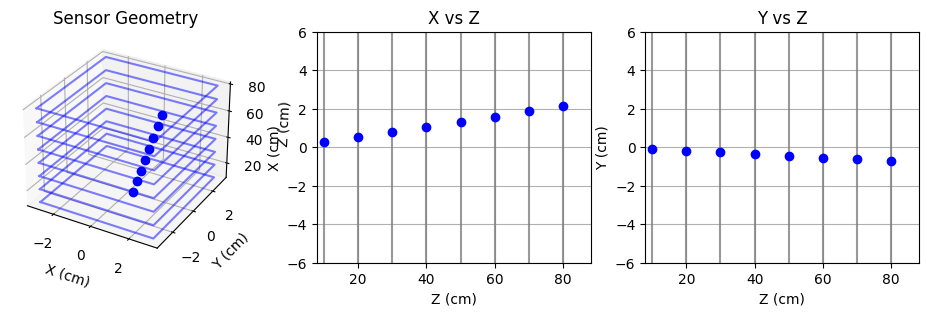

In [63]:
# Choose a random track
rand_trk_idx = np.random.randint(0, len(mc_tracks))
track = mc_tracks[rand_trk_idx]

fig = plt.figure(figsize=(12, 3))  # Wider to fit 3 plots

# 1. 3D sensor geometry
ax_3d = fig.add_subplot(1, 3, 1, projection='3d')
for sensor in sensors:
    x0, y0, z0 = sensor.position
    dx, dy = sensor.dx, sensor.dy
    ax_3d.plot(
        [x0 - dx/2, x0 + dx/2, x0 + dx/2, x0 - dx/2, x0 - dx/2],
        [y0 - dy/2, y0 - dy/2, y0 + dy/2, y0 + dy/2, y0 - dy/2],
        [z0]*5,
        color='blue', alpha=0.5
    )
ax_3d.set_xlabel('X (cm)')
ax_3d.set_ylabel('Y (cm)')
ax_3d.set_zlabel('Z (cm)')
ax_3d.set_title("Sensor Geometry")


# Extract coordinates
x_vals = [hit[1] for hit in track]
y_vals = [hit[2] for hit in track]
z_vals = [hit[3] for hit in track]

for hit in track:
    ax_3d.plot(hit[1], hit[2], hit[3], 'bo')

ax_xz = fig.add_subplot(1, 3, 2)
ax_yz = fig.add_subplot(1, 3, 3)

x_draw_min = min(s.position[0] - s.dx for s in sensors)
x_draw_max = max(s.position[0] + s.dx for s in sensors)
y_draw_min = min(s.position[1] - s.dy for s in sensors)
y_draw_max = max(s.position[1] + s.dy for s in sensors)
z_draw_min = 0.8*min(s.position[2] - s.dz for s in sensors)
z_draw_max = 1.1*max(s.position[2] + s.dz for s in sensors)

for s in sensors:
    ax_xz.axvline(s.position[2], color='gray', linestyle='-', alpha=0.8)
    ax_yz.axvline(s.position[2], color='gray', linestyle='-', alpha=0.8)

# 2. X vs Z
ax_xz.plot(z_vals, x_vals, 'bo')
ax_xz.set_xlabel('Z (cm)')
ax_xz.set_ylabel('X (cm)')
ax_xz.set_title("X vs Z")
ax_xz.set_ylim(x_draw_min,x_draw_max)
ax_xz.set_xlim(z_draw_min,z_draw_max)
ax_xz.grid(True)

# 3. Y vs Z
ax_yz.plot(z_vals, y_vals, 'bo')
ax_yz.set_xlabel('Z (cm)')
ax_yz.set_ylabel('Y (cm)')
ax_yz.set_title("Y vs Z")
ax_yz.set_ylim(y_draw_min,y_draw_max)
ax_yz.set_xlim(z_draw_min,z_draw_max)
ax_yz.grid(True)
